# V2.1

采用微调技术+ResNet-34

## Setup

run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import torch
import torchvision
from torch import nn

data_dir=os.path.join('..','data')

检查GPU

In [15]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


重新组织数据

In [16]:
from help import reorganize_data

batch_size=16
valid_ratio=0.1

reorganize_data(data_dir, valid_ratio)

数据增强

In [17]:
#图像增广
transform_train=torchvision.transforms.Compose([
    #缩放图像至224*224
    torchvision.transforms.Resize((224,224)),
    #随机水平翻转
    torchvision.transforms.RandomHorizontalFlip(),
    #随机更改亮度、对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),
    #转换为张量
    torchvision.transforms.ToTensor(),
    #标准化每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

transform_test=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

创建数据集

In [18]:
#创建ImageFolder数据集
train_dataset,train_valid_dataset=[torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_and_valid',folder),
    transform=transform_train) for folder in ['train','train_valid']]

valid_dataset=torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_and_valid','valid'),
    transform=transform_train)
test_dataset=torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'test'),
    transform=transform_test)

#数据迭代器
train_iter,train_valid_iter=[torch.utils.data.DataLoader(
    dataset,batch_size,shuffle=True,drop_last=True)
    for dataset in [train_dataset,train_valid_dataset]
]
valid_iter=torch.utils.data.DataLoader(valid_dataset,batch_size,shuffle=False,drop_last=True)
test_iter=torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False,drop_last=False)

加载模型(ResNet-34)

In [19]:
#创建预训练模型并微调
def get_net(devices) :
    finetune_net=nn.Sequential()
    finetune_net.features=torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
    #定义新输出网络，28个输出类别
    finetune_net.output_new=nn.Sequential(nn.Linear(1000,256),
                                          nn.ReLU(),
                                          nn.Linear(256,28))
    #将模型参数分配给可用于计算的CPU或GPU
    finetune_net=finetune_net.to(devices[0])
    #冻结参数
    for param in finetune_net.features.parameters() :
        param.requires_grad=False
    return finetune_net

训练和调参

train loss 0.407
383.6examples/sec on [device(type='cuda', index=0)]
accuracy rate:0.812


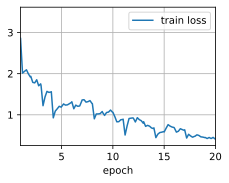

In [20]:
from help import try_all_gpus,train,evaluate_accuracy

#训练集训练
devices=try_all_gpus()
net=get_net(devices)

num_epochs,lr,wd=20,1e-3,1e-4
lr_period,lr_decay=2,0.9

train(net, train_iter, None, num_epochs, lr, wd, devices, lr_period,lr_decay)

evaluate_accuracy(valid_iter,net,devices)

测试集准确率

In [21]:
evaluate_accuracy(test_iter,net,devices)

accuracy rate:0.476
